# Breast Cancer Prediction
### Classification Task 
### Classes : Benign & Malignant
### Data Source: UCI
### Kernel: root, python3
#### To Do: 
1. Outlier Removal
2. Decision Boundary plot
3. Validation of own library - comp, perf, metrics
4. XGB,ANN

In [259]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import normalize, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, classification_report, confusion_matrix,                             roc_curve,auc, precision_recall_curve

In [ ]:
def optimal_threshold_prob(true_label,predicted_prob):
    precision, recall, threshold = precision_recall_curve(true_label, predicted_prob)
    p_r_o = pd.concat([pd.DataFrame(precision), pd.DataFrame(recall), pd.DataFrame(threshold)], axis =1)
    p_r_o.columns = ['precision', 'recall', 'threshold']
    p_r_o['f1'] = 2*p_r_o['precision']*p_r_o['recall']/(p_r_o['precision']+p_r_o['recall'])
    opt_index = np.argmax(p_r_o['f1'])
    #print(p_r_o)
    return threshold[opt_index]

def eval_roc(true_label, predicted_prob):
    fpr, tpr, threshold = roc_curve(true_label, predicted_prob)
    opt_prob = optimal_threshold_prob(true_label, predicted_prob)
    plt.plot(fpr, tpr)
    plt.title('ROC')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    return opt_prob

def generate_metrics(true_label, predicted_label):
    
    opt_thres_prob = eval_roc(true_label, predicted_label)
    predicted_class= pd.DataFrame(predicted_label).iloc[:,0].apply(lambda x: 1 if x>opt_thres_prob else 0)
    
    metrics = {}
    metrics['accuracy'] = accuracy_score(true_label, predicted_class)
    metrics['recall'] = recall_score(true_label, predicted_class)
    metrics['precision'] = precision_score(true_label, predicted_class)

    
    #print(confusion_matrix(true_label, predicted_class, labels = [1, 0]))
    #print(classification_report(true_label, predicted_class, labels = [1,0]))
    return metrics
    

#### Reading Data

In [16]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                header = None)

In [18]:
df.columns = ['_Sample_code_number',
                '_Clump_Thickness',
                '_Uniformity_of_Cell_Size',
                '_Uniformity_of_Cell_Shape',
                '_Marginal_Adhesion',
                '_Single_Epithelial_Cell_Size',
                '_Bare_Nuclei',
                '_Bland_Chromatin',
                '_Normal_Nucleoli',
                '_Mitoses',
                '_Class'
            ]

#### Converting 2->0, 4->1

In [20]:
df.iloc[:, -1] = df.iloc[:,-1].apply(lambda x: 0 if x == 2 else 1)

In [21]:
df.columns

Index(['_Sample_code_number', '_Clump_Thickness', '_Uniformity_of_Cell_Size',
       '_Uniformity_of_Cell_Shape', '_Marginal_Adhesion',
       '_Single_Epithelial_Cell_Size', '_Bare_Nuclei', '_Bland_Chromatin',
       '_Normal_Nucleoli', '_Mitoses', '_Class'],
      dtype='object')

#### Class Distribution

In [22]:
df._Class.value_counts()

0    458
1    241
Name: _Class, dtype: int64

#### NullValue Check

In [24]:
df.isnull().sum()

_Sample_code_number             0
_Clump_Thickness                0
_Uniformity_of_Cell_Size        0
_Uniformity_of_Cell_Shape       0
_Marginal_Adhesion              0
_Single_Epithelial_Cell_Size    0
_Bare_Nuclei                    0
_Bland_Chromatin                0
_Normal_Nucleoli                0
_Mitoses                        0
_Class                          0
dtype: int64

#### Structure

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
_Sample_code_number             699 non-null int64
_Clump_Thickness                699 non-null int64
_Uniformity_of_Cell_Size        699 non-null int64
_Uniformity_of_Cell_Shape       699 non-null int64
_Marginal_Adhesion              699 non-null int64
_Single_Epithelial_Cell_Size    699 non-null int64
_Bare_Nuclei                    699 non-null object
_Bland_Chromatin                699 non-null int64
_Normal_Nucleoli                699 non-null int64
_Mitoses                        699 non-null int64
_Class                          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


#### Summary Stats: Inference - Not normal

In [31]:
df.iloc[:, 1:].describe()

,_Clump_Thickness,_Uniformity_of_Cell_Size,_Uniformity_of_Cell_Shape,_Marginal_Adhesion,_Single_Epithelial_Cell_Size,_Bland_Chromatin,_Normal_Nucleoli,_Mitoses,_Class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,0.344778
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.475636
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


#### Categorical Attr

In [41]:
df.loc[:,'_Bare_Nuclei'].unique()

array(['1', '10', '2', '4', '3', '9', '7', '?', '5', '8', '6'], dtype=object)

In [110]:
df.loc[:,'_Bare_Nuclei'] = df.loc[:,'_Bare_Nuclei'].apply(lambda x: 'NA' if x =='?' else x)

In [111]:
df.loc[:, '_Bare_Nuclei'] = df.loc[:, '_Bare_Nuclei'].astype('category')

#### Numeric Attr

In [319]:
numeric_attr = [col for col in df.columns if col not in ['_Sample_code_number', '_Bare_Nuclei', '_Class']]

In [320]:
numeric_attr_df = df.loc[:, numeric_attr]

In [321]:
numeric_attr_df.columns

Index(['_Clump_Thickness', '_Uniformity_of_Cell_Size',
       '_Uniformity_of_Cell_Shape', '_Marginal_Adhesion',
       '_Single_Epithelial_Cell_Size', '_Bland_Chromatin', '_Normal_Nucleoli',
       '_Mitoses'],
      dtype='object')

In [322]:
cat_attr_df = df.loc[:, '_Bare_Nuclei']

#### Boxplot - Outlier Check

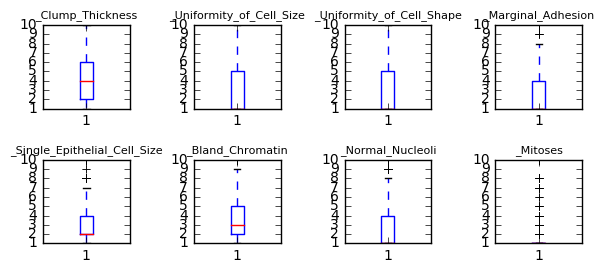

In [323]:
for i in range(len(numeric_attr_df.columns)):
    plt.subplot(3,4,i+1)
    plt.boxplot(numeric_attr_df.iloc[:,i])
    plt.title(numeric_attr_df.columns[i], fontsize = 8)
plt.tight_layout()

#### Cat Attr level frequency distribution check - Inference: Skewed

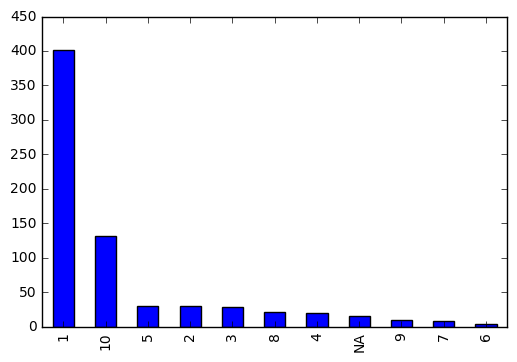

In [324]:
cat_attr_df.value_counts().plot(kind = 'bar')

#### Dummy Variables

In [325]:
cat_attr_df = pd.DataFrame(cat_attr_df)

In [326]:
cat_attr_df = pd.get_dummies(cat_attr_df)

#### Normalization

In [327]:
norm = normalize(numeric_attr_df.iloc[:,:-1])

In [328]:
cat_norm_df = pd.concat([pd.DataFrame(cat_attr_df), pd.DataFrame(norm)],  axis = 1)

In [342]:
final_df = pd.concat([df.iloc[:,[0,-1,1]], cat_norm_df],axis = 1)

In [343]:
final_df.head(10)

,_Sample_code_number,_Class,_Clump_Thickness,_Bare_Nuclei_1,_Bare_Nuclei_10,_Bare_Nuclei_2,_Bare_Nuclei_3,_Bare_Nuclei_4,_Bare_Nuclei_5,_Bare_Nuclei_6,...,_Bare_Nuclei_8,_Bare_Nuclei_9,_Bare_Nuclei_NA,0,1,2,3,4,5,6
0,1000025,0,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.771517,0.154303,0.154303,0.154303,0.308607,0.462910,0.154303
1,1002945,0,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.416667,0.333333,0.333333,0.416667,0.583333,0.250000,0.166667
2,1015425,0,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.588348,0.196116,0.196116,0.196116,0.392232,0.588348,0.196116
3,1016277,0,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.393919,0.525226,0.525226,0.065653,0.196960,0.196960,0.459573
4,1017023,0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.624695,0.156174,0.156174,0.468521,0.312348,0.468521,0.156174
5,1017122,1,8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.355292,0.444116,0.444116,0.355292,0.310881,0.399704,0.310881
6,1018099,0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.235702,0.235702,0.235702,0.235702,0.471405,0.707107,0.235702
7,1018561,0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.408248,0.204124,0.408248,0.204124,0.408248,0.612372,0.204124
8,1033078,0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.554700,0.277350,0.277350,0.277350,0.554700,0.277350,0.277350
9,1033078,0,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.718421,0.359211,0.179605,0.179605,0.359211,0.359211,0.179605


#### Train Validation Test Split - 80 - 10 - 10

In [344]:
train_X,val_test_X, train_Y, val_test_Y = train_test_split(final_df.iloc[:,2:],final_df.iloc[:,1],
                                                           test_size = 0.2,stratify = final_df.iloc[:,1])

In [345]:
val_X,test_X, val_Y, test_Y = train_test_split(val_test_X,val_test_Y, test_size = 0.5, stratify = val_test_Y)

### Model Building

#### 1. Logistic Regression

In [346]:
from sklearn.linear_model import LogisticRegression

In [347]:
lr_model = LogisticRegression()
lr_model.fit(train_X, train_Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [348]:
lr_train_pred = lr_model.predict_proba(train_X)
lr_val_pred = lr_model.predict_proba(val_X)

#### Metrics

,0
recall,0.968912
accuracy,0.971377
precision,0.949239


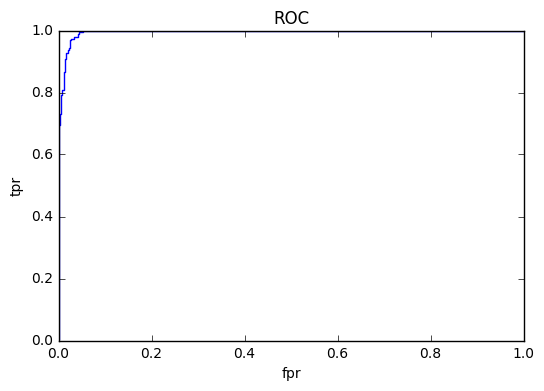

In [349]:
pd.DataFrame.from_dict(generate_metrics(train_Y, lr_train_pred[:,1]), orient = 'index')

,0
recall,0.875000
accuracy,0.928571
precision,0.913043


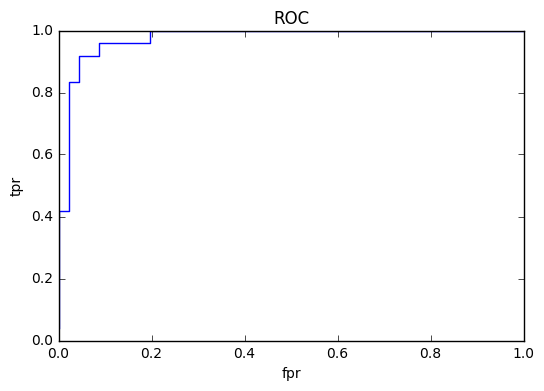

In [350]:
pd.DataFrame.from_dict(generate_metrics(val_Y, lr_val_pred[:,1]), orient = 'index')

#### 2. GradientBoosting 

In [353]:
from sklearn.ensemble import GradientBoostingClassifier

In [354]:
gbm_model = GradientBoostingClassifier()
gbm_model.fit(train_X, train_Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [357]:
gbm_train_pred = gbm_model.predict_proba(train_X)
gbm_val_pred = gbm_model.predict_proba(val_X)

#### Metrics

,0
recall,0.994819
accuracy,0.998211
precision,1.000000


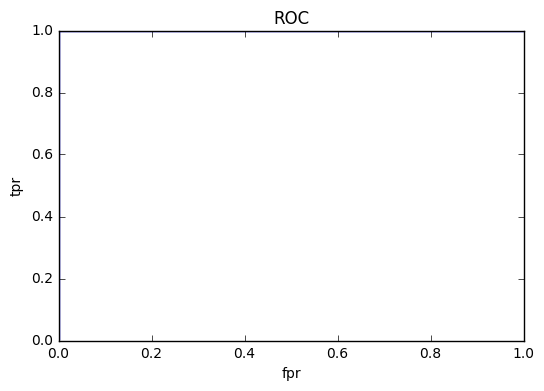

In [358]:
pd.DataFrame.from_dict(generate_metrics(train_Y, gbm_train_pred[:,1]), orient = 'index')

,0
recall,0.916667
accuracy,0.957143
precision,0.956522


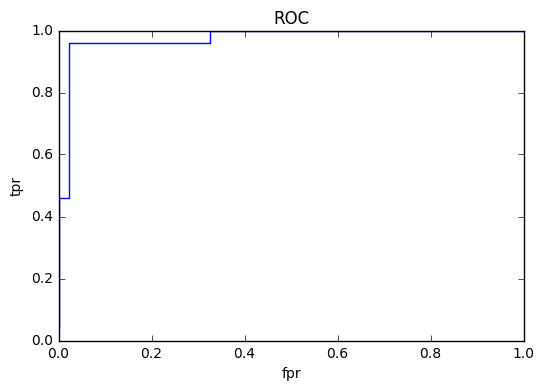

In [360]:
pd.DataFrame.from_dict(generate_metrics(val_Y, gbm_val_pred[:,1]), orient = 'index')

#### 3. ADB

In [361]:
from sklearn.ensemble import AdaBoostClassifier

In [362]:
adb_model = AdaBoostClassifier()
adb_model.fit(train_X, train_Y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [363]:
adb_train_pred = adb_model.predict_proba(train_X)
adb_val_pred = adb_model.predict_proba(val_X)

,0
recall,0.994819
accuracy,0.998211
precision,1.000000


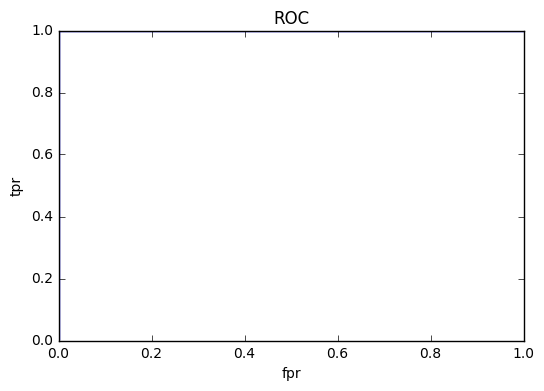

In [365]:
pd.DataFrame.from_dict(generate_metrics(train_Y, adb_train_pred[:,1]), orient = 'index')

,0
recall,0.875000
accuracy,0.942857
precision,0.954545


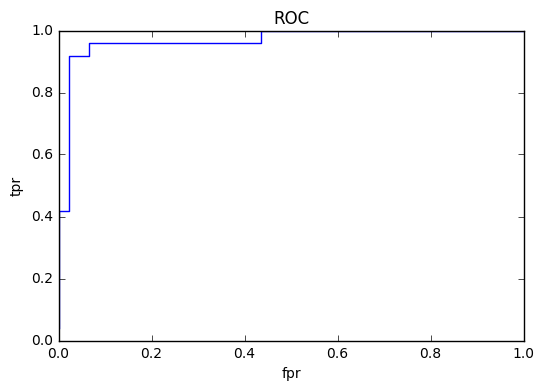

In [366]:
pd.DataFrame.from_dict(generate_metrics(val_Y, adb_val_pred[:,1]), orient = 'index')

#### 4. SVM

In [367]:
from sklearn.svm import SVC

In [373]:
svm_model = SVC(probability=True)

In [374]:
svm_model.fit(train_X, train_Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [375]:
svm_train_pred = svm_model.predict_proba(train_X)
svm_val_pred = svm_model.predict_proba(val_X)

,0
recall,0.989637
accuracy,0.971377
precision,0.931707


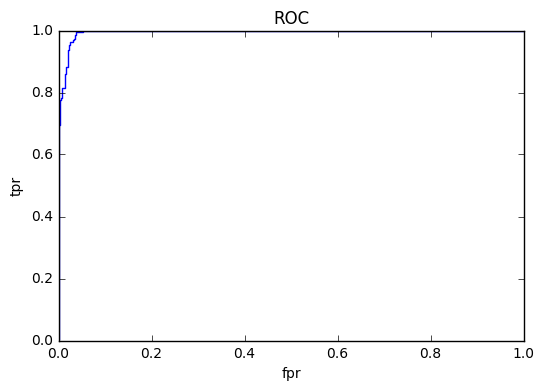

In [377]:
pd.DataFrame.from_dict(generate_metrics(train_Y, svm_train_pred[:,1]), orient = 'index')

,0
recall,0.875000
accuracy,0.928571
precision,0.913043


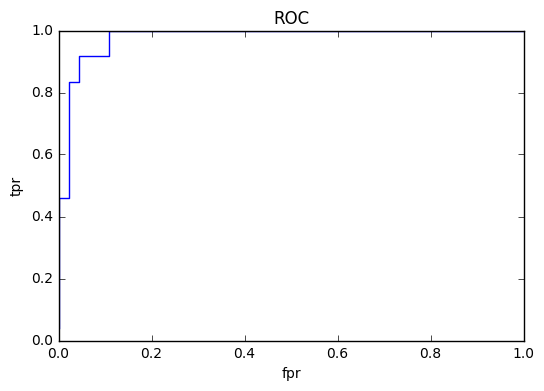

In [378]:
pd.DataFrame.from_dict(generate_metrics(val_Y, svm_val_pred[:,1]), orient = 'index')